# Лабораторная работа №8. Сверточные нейронные сети для классификации визуальных образов

# Plant leaf diseases classification using CNN

О данном наборе данных  

Набор данных PlantVillage организован в три отдельных папки: train (обучение), test (тестирование) и validation (валидация). Каждая из этих папок содержит в общей сложности 15 подпапок, соответствующих 15 уникальным классам заболеваний растений. Такая тщательная классификация позволяет эффективно и точно различать различные типы пораженных листьев растений.  

В наборе данных изображения разделены по стратегическому принципу: 80% всех изображений находятся в папке train, 10% — в папке test и оставшиеся 10% — в папке validation. Такое распределение обеспечивает надежную оценку моделей, предоставляя достаточно данных для обучения, объективного тестирования и точной валидации. В результате исследователи и разработчики могут использовать этот хорошо структурированный набор данных для создания и настройки алгоритмов, которые эффективно выявляют и устраняют различные заболевания растений, способствуя улучшению сельскохозяйственных практик и управлению урожаем.

<br>
https://www.kaggle.com/code/moazeldsokyx/plant-leaf-diseases-classification-using-cnn/input

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/dataset'

# Просмотр содержимого папки с данными
os.listdir(dataset_path)

['validation', 'test', 'train']

In [ ]:
# Определяем пути для обучающего, валидационного и тестового наборов данных
train_path = os.path.join(dataset_path, 'train')
validation_path= os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

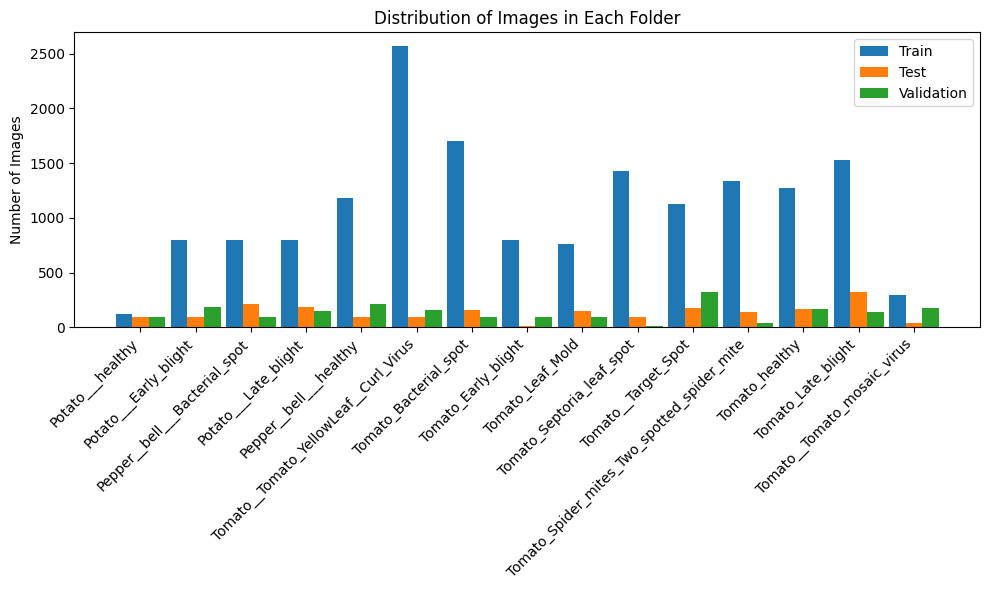

In [ ]:
# Список папок с наборами данных и словарь для хранения количества изображений
folders = ['train', 'test', 'validation']

subfolder_lengths = {folder: {} for folder in folders}

# Подсчет количества изображений в каждой папке (для каждого класса)
for folder in folders:
    subfolders = os.listdir(os.path.join(dataset_path, folder))
    for subfolder in subfolders:
        subfolder_length = len(os.listdir(os.path.join(dataset_path, folder, subfolder)))
        subfolder_lengths[folder][subfolder] = subfolder_length

# Извлечение названий поддиректорий и количества изображений для построения графиков
subfolder_names = list(subfolder_lengths['train'].keys())
train_lengths = list(subfolder_lengths['train'].values())
test_lengths = list(subfolder_lengths['test'].values())
val_lengths = list(subfolder_lengths['validation'].values())

# Построение столбчатой диаграммы для визуализации распределения изображений
x = np.arange(len(subfolder_names))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
# Создаем столбцы для обучающего, тестового и валидационного наборов данных
rects1 = ax.bar(x - width, train_lengths, width, label='Train')
rects2 = ax.bar(x, test_lengths, width, label='Test')
rects3 = ax.bar(x + width, val_lengths, width, label='Validation')

ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images in Each Folder')
ax.set_xticks(x)
ax.set_xticklabels(subfolder_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

## Leaves picture

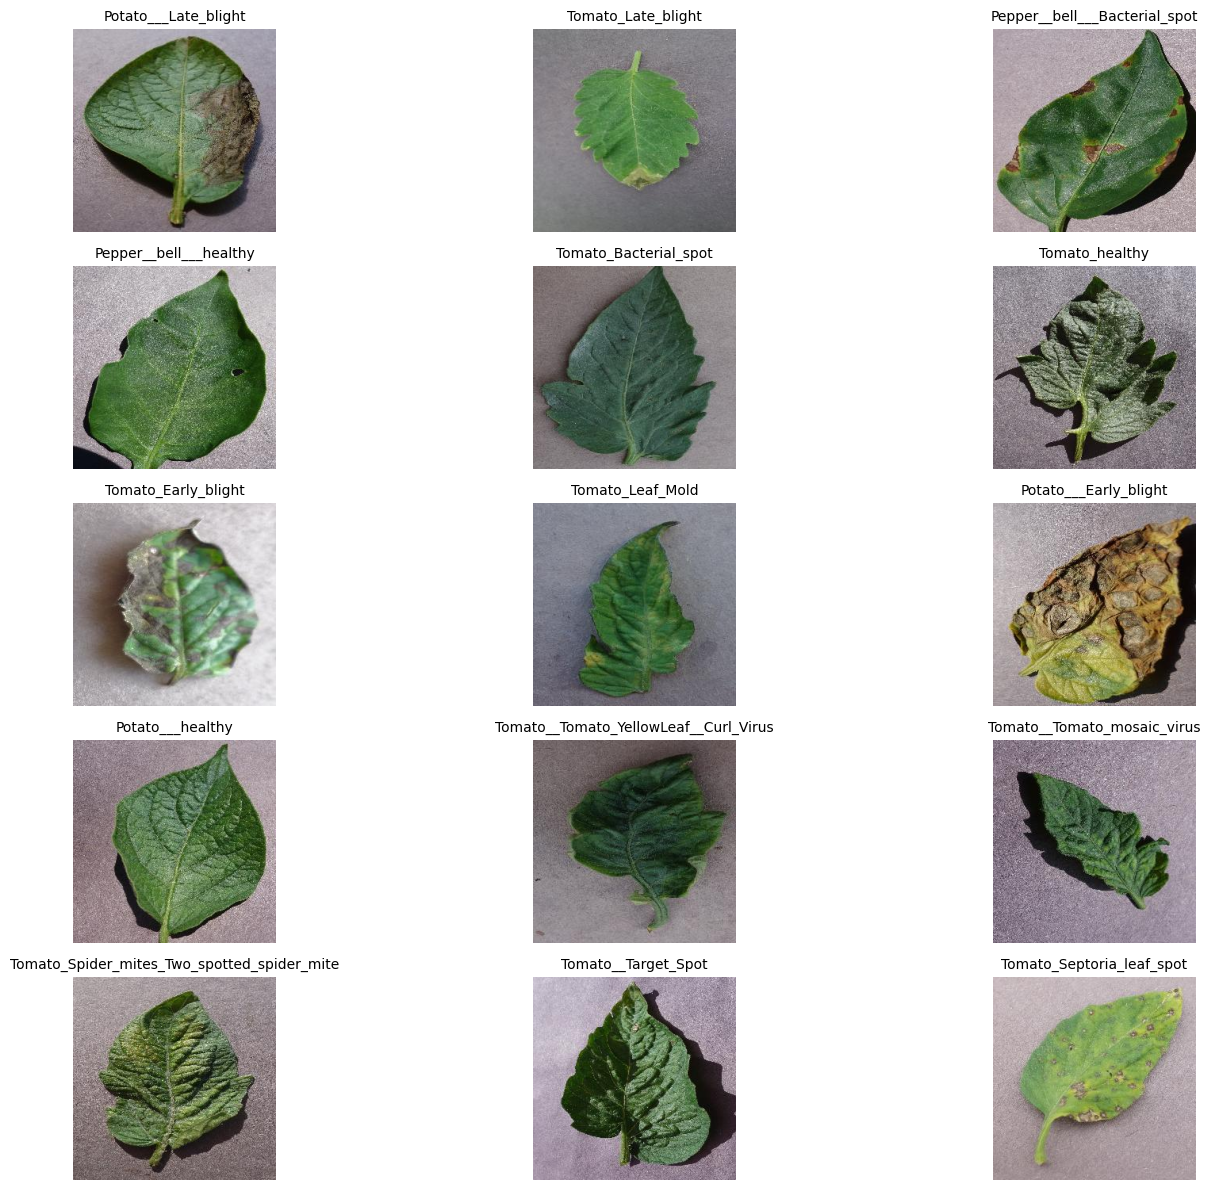

In [ ]:
# Настраиваем сетку для отображения примеров изображений
num_cols = 3
num_rows= 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16,12))
axes = axes.ravel()  # Преобразуем сетку в одномерный массив

# loop through subfolders and display an image from each
# Отображаем первые изображения из каждой поддиректории
for i, subfolder in enumerate(subfolders):
    img = [image for image in os.listdir(os.path.join(train_path, subfolder))][0]
    img_path = os.path.join(train_path, subfolder, img) # get the first image in the subfolder
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(subfolder, color='black', fontsize=10)

plt.tight_layout()
plt.show()

## Building the CNN Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Train

In [ ]:
# Определяем размер мини-выборки и размеры изображений
batch_size = 32
image_shape= (256, 256)

# Создаем генератор изображений с аугментацией для обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1/255, # Нормализация пикселей к диапазону [0, 1]
    shear_range=0.2, # Сдвиг изображений
    zoom_range=0.2, # Зумирование
    horizontal_flip=True,
    vertical_flip= True,
    brightness_range= [.5, 1.5],
    rotation_range= 40,

)

# Генератор обучающей выборки
train_generator= train_datagen.flow_from_directory(
    train_path,
    target_size= image_shape,
    batch_size= batch_size,
    class_mode= 'categorical',
)

Found 16514 images belonging to 15 classes.


### Validation

In [ ]:
# Генератор валидационной выборки (только нормализация)
validation_datagen= ImageDataGenerator(
    rescale=1/255,
)

validation_generator= validation_datagen.flow_from_directory(
    validation_path,
    target_size= image_shape,
    batch_size= batch_size,
    class_mode= 'categorical',
)

Found 2070 images belonging to 15 classes.


### Test

In [ ]:
# Генератор тестовой выборки (только нормализация)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False

)

Found 2064 images belonging to 15 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(42)

# build the CNN model
model = Sequential()

# Первый свёрточный слой с фильтрами 32 и размером ядра 3x3
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

# Второй свёрточный слой с фильтрами 64
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Третий свёрточный слой с фильтрами 64
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Четвертый свёрточный слой с фильтрами 64
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Преобразование 2D-данных в 1D (вектор)
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2)) # Удаление части нейронов для регуляризации
model.add(Dense(128, activation='relu'))

model.add(Dense(15, activation='softmax'))

# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# define a ModelCheckPoint callback to save the best weights during training
checkpoint_callback = ModelCheckpoint("best_epoch_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,583,887 (25.12 MB)

 Trainable params: 6,583,887 (25.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
tf.random.set_seed(42)

steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs= 20

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= validation_steps,
    callbacks=[checkpoint_callback]
)

# find the epoch with the best accuracy on the validation (test) set
best_epoch = np.argmax(history.history['val_accuracy']) +1

print(f'Best epoch is ====> epoch {best_epoch}')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3053 - loss: 2.1309
Epoch 1: val_accuracy improved from -inf to 0.64795, saving model to best_epoch_weights.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 5565s 11s/step - accuracy: 0.3056 - loss: 2.1300 - val_accuracy: 0.6479 - val_loss: 1.0750
Epoch 2/20
  1/516 ━━━━━━━━━━━━━━━━━━━━ 52:37 6s/step - accuracy: 0.5312 - loss: 1.4852

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.64795
516/516 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5312 - loss: 1.4852 - val_accuracy: 0.5909 - val_loss: 1.2503
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6842 - loss: 0.9314
Epoch 3: val_accuracy improved from 0.64795 to 0.75293, saving model to best_epoch_weights.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 2691s 5s/step - accuracy: 0.6842 - loss: 0.9312 - val_accuracy: 0.7529 - val_loss: 0.8396
Epoch 4/20
  1/516 ━━━━━━━━━━━━━━━━━━━━ 31:49 4s/step - accuracy: 0.7500 - loss: 0.6779
Epoch 4: val_accuracy did not improve from 0.75293
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7500 - loss: 0.6779 - val_accuracy: 0.6818 - val_loss: 1.1560
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7649 - loss: 0.6881
Epoch 5: val_accuracy did not improve from 0.75293
516/516 ━━━━━━━━━━━━━━━━━━━━ 2735s 5s/step - accuracy: 0.7650 - loss: 0.6880 - val_accuracy: 0.7280 - val_loss: 0.8879
Epoch 6/20
  1/516 

In [ ]:
# Загрузка лучших весов модели для оценки
best_model = model

# Compile the best_model
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
best_model.load_weights(r'/content/best_epoch_weights.keras')

# Сохранение всей модели для последующего использования
best_model.save("plant_leaf_diseases_model.h5")
# Now we can use the 'best_model' for predictions or further evaluation
print("Training done and best model saved")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training done and best model saved


In [ ]:
evaluation = best_model.evaluate(test_generator,verbose=0)
print(f"Test Accuracy = {round(evaluation[1],2)}")
print(f"Test Loss = {round(evaluation[0],3)}")

Test Accuracy = 0.92
Test Loss = 0.27


In [ ]:
# Оценка модели на тестовой выборке
test_score, test_accuracy = best_model.evaluate(test_generator, verbose=1)

# Вывод результатов
print(f"Точность на тестовой выборке: {test_accuracy * 100:.2f}%")
print(f"Потери на тестовой выборке: {test_score:.4f}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9222 - loss: 0.2507
Точность на тестовой выборке: 91.72%
Потери на тестовой выборке: 0.2695


## Model Accuracy

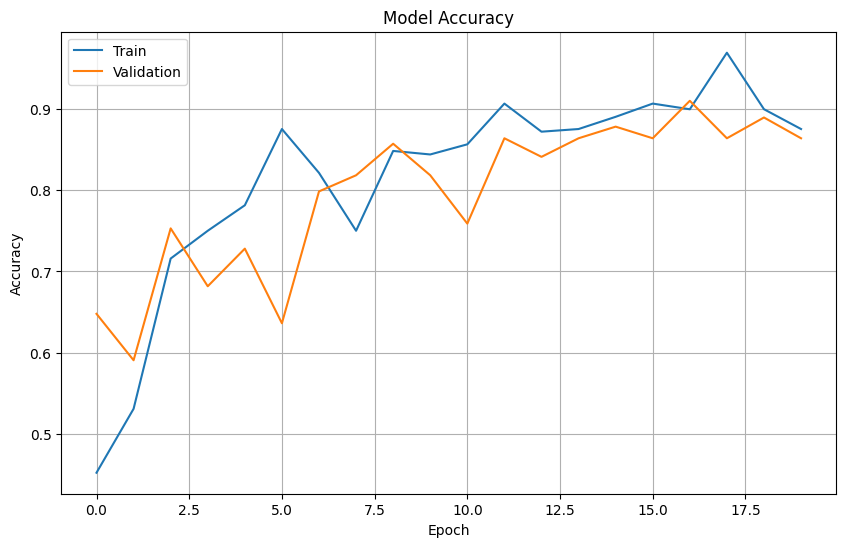

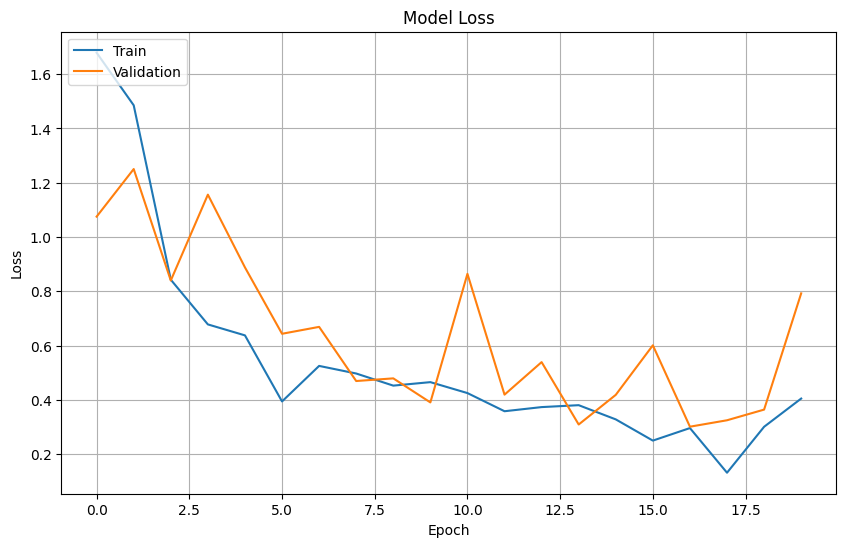

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned from model.fit()

# Построение графиков точности и валидации
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Построение графиков потерь
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

## Predicted Test

In [ ]:
# Сброс генератора тестовых данных для корректного предсказания
test_generator.reset()

# Генерация предсказаний для тестовых изображений
predictions = best_model.predict(test_generator, verbose=1)

# Определяем предсказанные классы (максимум вероятности)
predicted_classes = np.argmax(predictions, axis=1)

# Получаем истинные метки (actual) из генератора
true_classes = test_generator.classes

# Преобразование индексов в названия классов
class_labels = list(test_generator.class_indices.keys())  # Названия классов
actual_labels = [class_labels[idx] for idx in true_classes]  # Истинные метки
predicted_labels = [class_labels[idx] for idx in predicted_classes]  # Предсказанные метки

# Печать первых нескольких значений для проверки
print("Истинные и предсказанные метки:")
for i in range(len(actual_labels)):
    print(f"Actual: {actual_labels[i]} - Predicted: {predicted_labels[i]}")
    if i == 5:  # Выводим только первые 5 записей, чтобы избежать длинного списка
        break


65/65 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step
Истинные и предсказанные метки:
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot


In [ ]:
# Сброс генератора тестовых данных для корректного предсказания
test_generator.reset()

# Генерация предсказаний для тестовых изображений
predictions = best_model.predict(test_generator, verbose=1)

# Определяем предсказанные классы (максимум вероятности)
predicted_classes = np.argmax(predictions, axis=1)

# Получаем истинные метки (actual) из генератора
true_classes = test_generator.classes

# Преобразование индексов в названия классов
class_labels = list(test_generator.class_indices.keys())  # Названия классов
actual_labels = [class_labels[idx] for idx in true_classes]  # Истинные метки
predicted_labels = [class_labels[idx] for idx in predicted_classes]  # Предсказанные метки

# Печать первых нескольких значений для проверки
print("Истинные и предсказанные метки:")
for i in range(len(actual_labels)):
    print(f"Actual: {actual_labels[i]} - Predicted: {predicted_labels[i]}")
    if i == 20:  # Выводим только первые 20 записей, чтобы избежать длинного списка
        break


65/65 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step
Истинные и предсказанные метки:
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot - Predicted: Pepper__bell___Bacterial_spot
Actual: Pepper__bell___Bacterial_spot 